## Artificial Neural Network

### Libraries

In [14]:
# standart data tools
import numpy as np
import pandas as pd

# common visualizing tools
import matplotlib.pyplot as plt
import seaborn as sns

# CNN layers and the Deep Learning model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense , Flatten, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner.tuners import RandomSearch


# splitting tool for the validation set
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

### Data Loading

In [15]:
X = np.load('archive/X_2024-03-18_18-10-54.npy')
y = np.load('archive/Y_2024-03-18_18-10-54.npy')

### Splitting Train (70%), Validation (15%) and Test Datasets (15%)

In [16]:
x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

x_train = x_train.reshape(-1, 64, 64, 1)
x_val = x_val.reshape(-1, 64, 64, 1)
x_test = x_test.reshape(-1, 64, 64, 1)

### Creating the ANN Model

In [329]:
ANN_model = Sequential([
  Flatten(),
  Dense(512, activation="relu", kernel_regularizer=l2(0.001)),
  Dropout(0.3),
  Dense(256, activation="relu", kernel_regularizer=l2(0.001)),
  Dropout(0.2),
  Dense(10, activation="softmax")
])

### Summary of the Model

In [330]:
ANN_model.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_35 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Compilation

In [331]:
ANN_model.compile(optimizer=Adam(learning_rate=0.00002), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

### Training

In [332]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

results = ANN_model.fit(x_train, y_train, epochs=600, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/600


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.1033 - loss: 3.7409 - val_accuracy: 0.2168 - val_loss: 3.4768
Epoch 2/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1413 - loss: 3.5370 - val_accuracy: 0.2492 - val_loss: 3.4111
Epoch 3/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1461 - loss: 3.4696 - val_accuracy: 0.2848 - val_loss: 3.3583
Epoch 4/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1921 - loss: 3.4076 - val_accuracy: 0.3883 - val_loss: 3.3078
Epoch 5/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2023 - loss: 3.3698 - val_accuracy: 0.4239 - val_loss: 3.2648
Epoch 6/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2130 - loss: 3.3301 - val_accuracy: 0.4239 - val_loss: 3.2175
Epoch 7/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2497 - loss: 3.2736 - val_accuracy: 0.4563 - val_loss: 3.1691
Epoch 8/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2543 - loss: 3.2272 - val_accuracy: 0.3916 - val_l

KeyboardInterrupt: 

### Plotting Training and Validating Accuracy/Loss

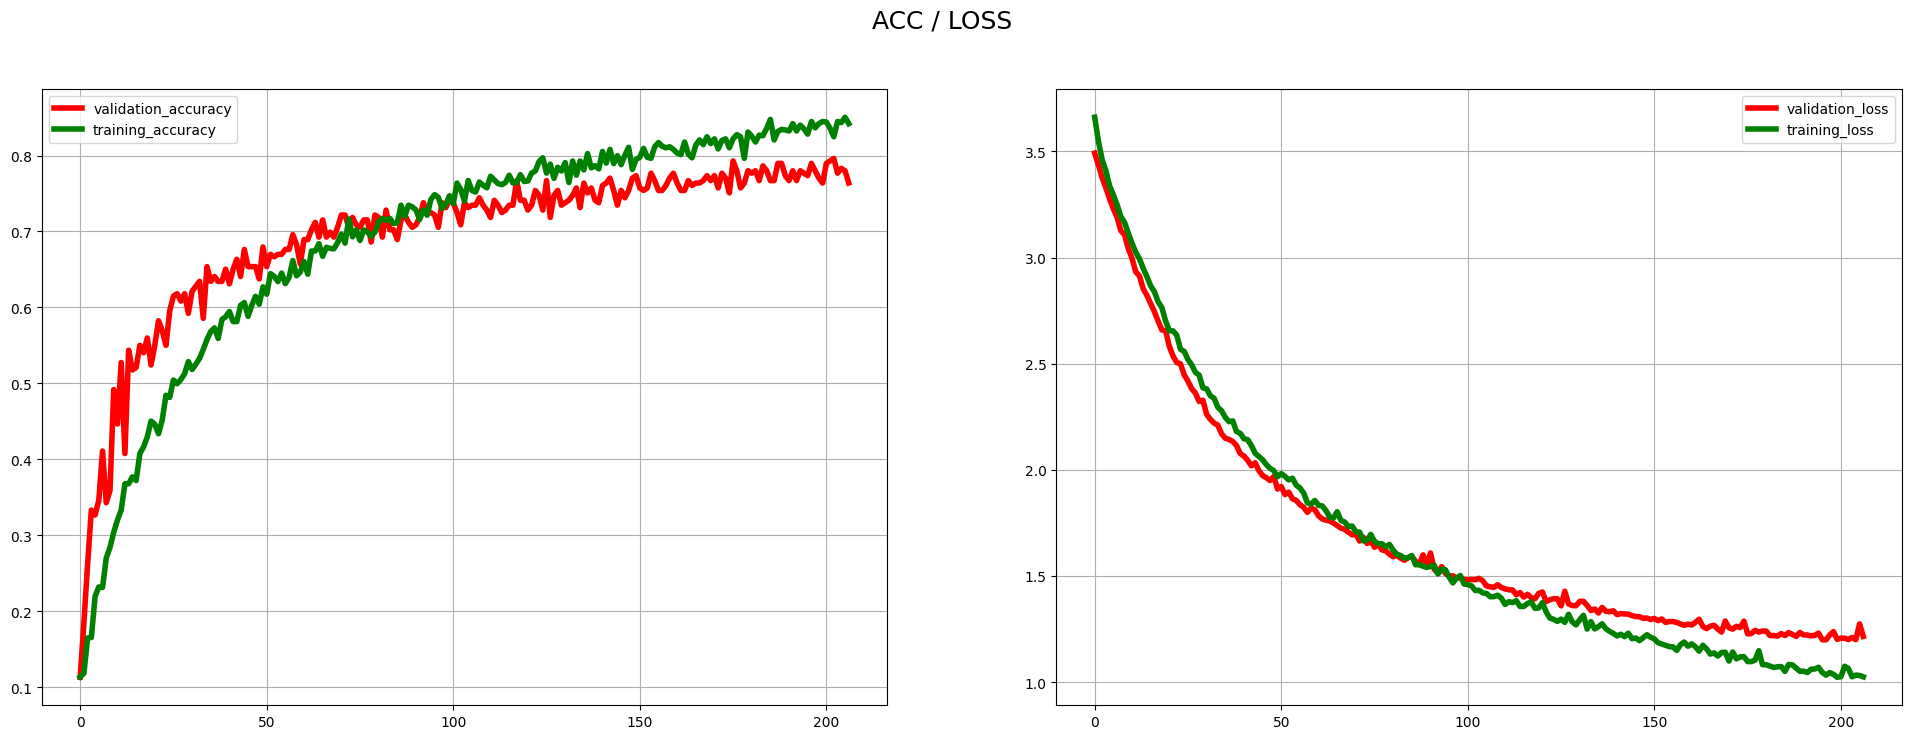

In [ ]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.plot(results.history["val_accuracy"],label="validation_accuracy",c="red",linewidth=4)
plt.plot(results.history["accuracy"],label="training_accuracy",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(results.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(results.history["loss"],label="training_loss",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.suptitle("ACC / LOSS",fontsize=18)

plt.show()

### Test Set Analysis

In [ ]:
y_pred = ANN_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print(classification_report(y_test_classes, y_pred_classes))

 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
              precision    recall  f1-score   support

           0       0.93      0.96      0.95        28
           1       0.75      0.84      0.79        32
           2       0.81      0.51      0.63        41
           3       0.88      0.67      0.76        33
           4       0.59      0.50      0.54        20
           5       0.77      0.97      0.86        31
           6       0.80      0.77      0.79        31
           7       0.68      0.87      0.76        30
           8       0.81      0.76      0.79        34
           9       0.71      0.90      0.79        30

    accuracy                           0.77       310
   macro avg       0.77      0.78      0.77       310
weighted avg       0.78      0.77      0.77       310



### Confusion Matrix

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


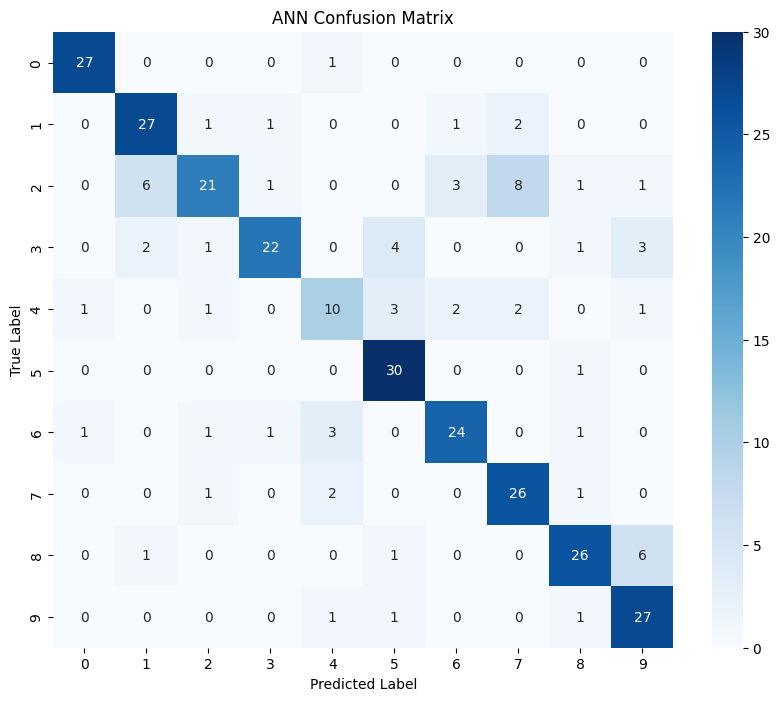

In [ ]:
y_pred = ANN_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(np.argmax(y_test,axis=1),y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('ANN Confusion Matrix')
plt.show()

### Predictions

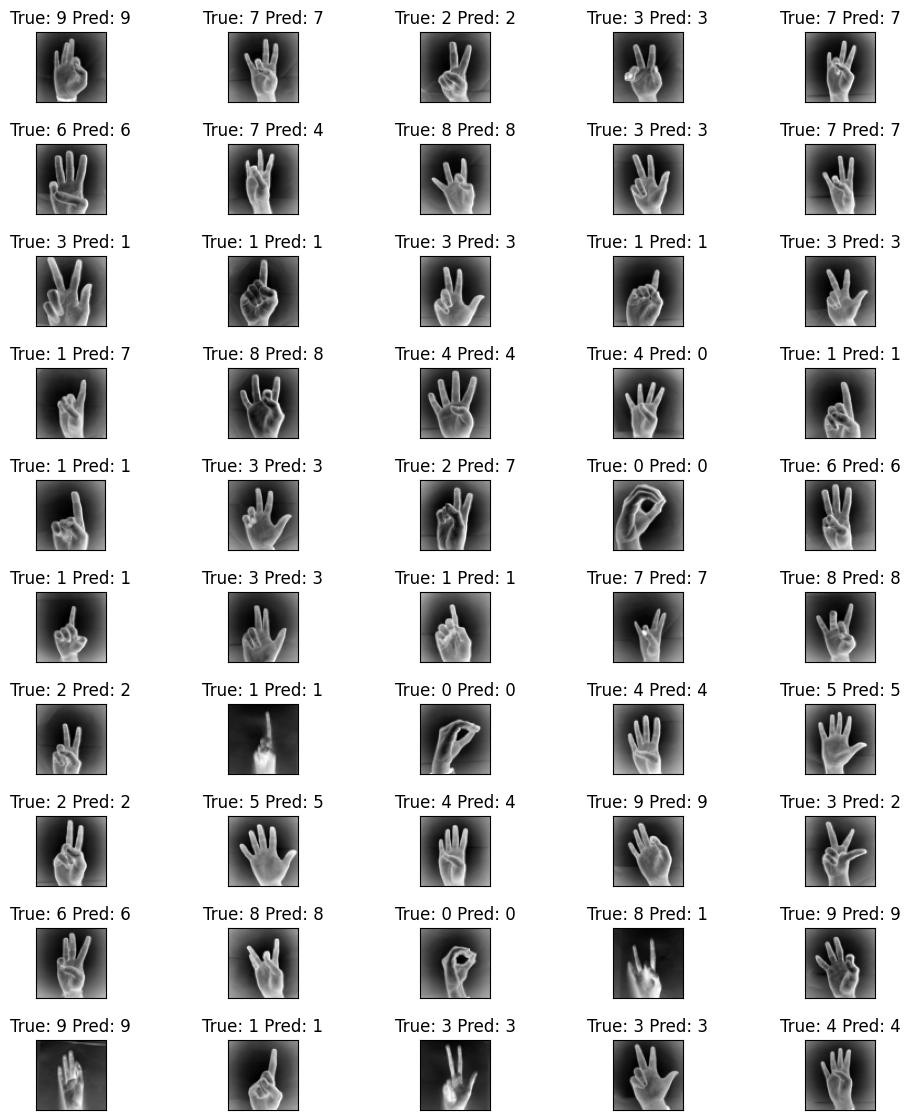

In [ ]:
x_val_test =  x_test.reshape(x_test.shape[0], 64, 64)

fig , axis = plt.subplots(10, 5, figsize = (12, 14))

for i, ax in enumerate(axis.flat):
    ax.imshow(x_val_test[i], cmap = 'binary')
    ax.set(title = f"True: {y_test[i].argmax()} Pred: {y_pred[i].argmax()}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(hspace=0.6)
plt.show()

## Hyperparameter Tuning

In [13]:
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(x_train.shape[1:])))
    model.add(Dense(units=hp.Int('units_layer_1', min_value=256, max_value=1024, step=256),
                    activation='relu',
                    kernel_regularizer=l2(hp.Float('l2_layer_1', min_value=1e-4, max_value=1e-2, sampling='log'))))
    model.add(Dropout(hp.Float('dropout_layer_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_layer_2', min_value=128, max_value=512, step=128),
                    activation='relu',
                    kernel_regularizer=l2(hp.Float('l2_layer_2', min_value=1e-4, max_value=1e-2, sampling='log'))))
    model.add(Dropout(hp.Float('dropout_layer_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
                  loss=keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])
    
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # Número máximo de combinações de hiperparâmetros para testar
    executions_per_trial=1,  # Número de modelos que devem ser construídos e ajustados para cada tentativa
    directory='ANN_tuning',  # Diretório onde os logs de sumário devem ser salvos
    project_name='keras_tuner_ANN'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

tuner.search(x_train, y_train, epochs=600, validation_data=(x_val, y_val), callbacks=[early_stopping])

# Obtendo o melhor modelo
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
    Melhores hiperparâmetros encontrados:
      - Número de neurônios na camada 1: {best_hps.get('units_layer_1')}
      - Taxa de regularização L2 na camada 1: {best_hps.get('l2_layer_1')}
      - Taxa de dropout na camada 1: {best_hps.get('dropout_layer_1')}
      - Número de neurônios na camada 2: {best_hps.get('units_layer_2')}
      - Taxa de regularização L2 na camada 2: {best_hps.get('l2_layer_2')}
      - Taxa de dropout na camada 2: {best_hps.get('dropout_layer_2')}
      - Taxa de aprendizado: {best_hps.get('learning_rate')}
      """)

tuned_ANN_model = tuner.hypermodel.build(best_hps)
tuned_results = tuned_ANN_model.fit(x_train, y_train, epochs=600, validation_data=(x_val, y_val), callbacks=[early_stopping])


Trial 20 Complete [00h 03m 03s]
val_accuracy: 0.10355987399816513

Best val_accuracy So Far: 0.844660222530365
Total elapsed time: 02h 10m 51s

    Melhores hiperparâmetros encontrados:
      - Número de neurônios na camada 1: 1024
      - Taxa de regularização L2 na camada 1: 0.0008352082168605626
      - Taxa de dropout na camada 1: 0.2
      - Número de neurônios na camada 2: 128
      - Taxa de regularização L2 na camada 2: 0.0012939269669747188
      - Taxa de dropout na camada 2: 0.1
      - Taxa de aprendizado: <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
      


AttributeError: 'Sequential' object has no attribute 'Int'

### Plotting Training and Validating Accuracy/Loss

In [ ]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.plot(tuned_results.history["val_accuracy"],label="validation_accuracy",c="red",linewidth=4)
plt.plot(tuned_results.history["accuracy"],label="training_accuracy",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(tuned_results.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(tuned_results.history["loss"],label="training_loss",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.suptitle("ACC / LOSS",fontsize=18)

plt.show()

### Test Set Analysis

In [ ]:
tuned_y_pred = tuned_ANN_model.predict(x_test)
tuned_y_pred_classes = np.argmax(tuned_y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print(classification_report(y_test_classes, tuned_y_pred_classes))

### Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_test,axis=1),tuned_y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('ANN Confusion Matrix')
plt.show()

### Predictions

In [ ]:
x_val_test =  x_test.reshape(x_test.shape[0], 64, 64)

fig , axis = plt.subplots(10, 5, figsize = (12, 14))

for i, ax in enumerate(axis.flat):
    ax.imshow(x_val_test[i], cmap = 'binary')
    ax.set(title = f"True: {y_test[i].argmax()} Pred: {tuned_y_pred[i].argmax()}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(hspace=0.6)
plt.show()